In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt


# ARIMA
Lags -> In auto regressive there are some value which is calleed lags, suppose today our output is Y it is actually dependent on some data on previous day so those previous days are lags.

Seasonal data -> In time series data, seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly. Seasonality may be caused by various factors, such as weather, vacation, and holidays and consists of periodic, repetitive, and generally regular and predictable patterns in the levels of a time series.

In order to check our data is stationary or not by seeing the mean and the variance weather it almost same we basically apply something called Dickey–Fuller test.

Dickey–Fuller -> In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The test is named after the statisticians David Dickey and Wayne Fuller, who developed it in 1979.

NullHypothesis -> In inferential statistics, the null hypothesis is that two possibilities are the same. The null hypothesis is that the observed difference is due to chance alone. Using statistical tests, it is possible to calculate the likelihood that the null hypothesis is true.

In [2]:
df = pd.read_excel('Infosys_Stock_Price_Dataset.xlsx', usecols=['Date', 'High'])
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date',inplace=True)
# df.head()

<AxesSubplot: title={'center': 'Infosys daily stock price'}, xlabel='Date', ylabel='High price (INR)'>

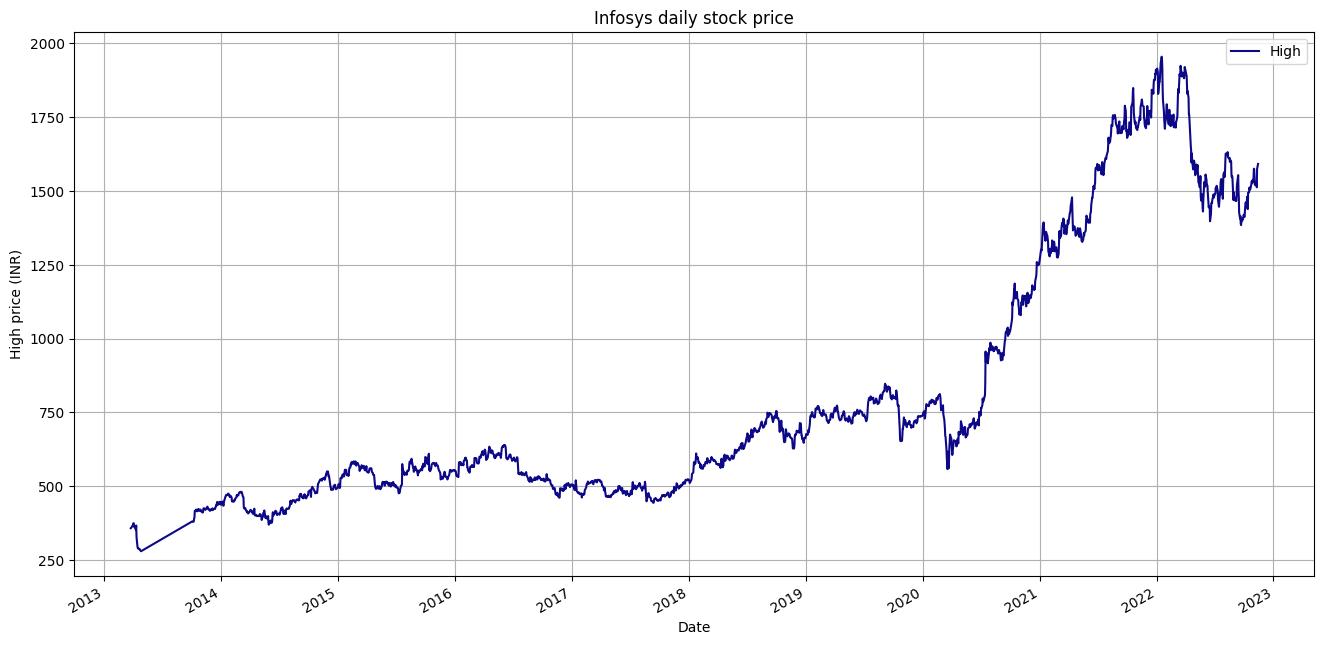

In [3]:
df.plot(x = 'Date', y = 'High', figsize=(16,8), title='Infosys daily stock price', grid=True, ylabel='High price (INR)', colormap='plasma')

Here we use adfuller from stats model for the dickey-fuller test. It takes the entire dataset and return five different values those are 'ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'. The most important thing we require is p-value. Dickey-fuller test it is kind of hypothesis testing where in the Null hypothesis says that the data is not a stationary where as my alternate hypothesis says that it is stationary so, based on this particular condition is my p-value is < 0.05 it basically says that Data has no unit root and is stationary that means if we are getting 0.05 we are rejecting Nullhypothesis and if we are rejecting the nullhypothesis by deafult the alternate hypothesis get selected that is called as it is stationary. 
If our data is non stationary then we have to make our data stationary for that we can do Differencing.

Differencing -> In this method we are shifting the required number position of the price data or required data filed that means that number of record will move down. Once our data is stationary that means we are rejecting Null hypothesis and accepting the alternate hypothesis.

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(f'{label}: {value:.4f}')
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df['High'])

In [ ]:
autocorrelation_plot(df['High'])
plt.show()

In [ ]:
df['stationary_high'] = df['High'] - df['High'].shift(1)
df.head()

In [ ]:
adfuller_test(df['stationary_high'].dropna())

In [ ]:
df['stationary_high'].plot(figsize=(16,8), title='Infosys daily stock price', grid=True, ylabel='High price (INR)', colormap='plasma')

In [ ]:
autocorrelation_plot(df['stationary_high'])
plt.show()

Autocorrelation and Partial Autocorrelation
Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
p -> AR model lags
d -> differencing
q -> MA lags

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['stationary_high'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['stationary_high'].iloc[1:],lags=40,ax=ax2)

In [ ]:
def get_best_pdq(df_data):
    flt_best_aic = None
    tup_best_pdq = None
    p = d = q = range(0, 5)
    lst_pdq = list(product(p, d, q))
    for tup_pdq in tqdm_notebook(lst_pdq):
        try:
            model_arima = ARIMA(df_data, order = tup_pdq)
            model_arima_fit = model_arima.fit()
            if flt_best_aic is None:
                flt_best_aic = model_arima_fit.aic
            elif model_arima_fit.aic < flt_best_aic:
                flt_best_aic = model_arima_fit.aic
                tup_best_pdq = tup_pdq
        except:
            continue
    return tup_best_pdq

In [ ]:
get_best_pdq(df['stationary_high'])

In [4]:
model=ARIMA(df['High'], order=(4, 0, 4), trend='t')
model_fit=model.fit()
model_fit.summary()

c:\Users\laxmi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 2275
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -9205.463
Date:                Mon, 28 Nov 2022   AIC                          18430.925
Time:                        19:59:44   BIC                          18488.222
Sample:                             0   HQIC                         18451.827
                               - 2275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4688      0.287      1.632      0.103      -0.094       1.032
ar.L1          0.2174      0.080      2.732      0.006       0.061       0.373
ar.L2          0.0855      0.073      1.167      0.243      -0.058       0.229
ar.L3         -0.1370      0.072     -1.910      0.056      -0.278       0.004
ar.L4          0.8333      0.062     13.477      0.000       0.712       0.954
ma.L1          0.8737      0.080     10.938      0.000       0.717       1.030
ma.L2          0.7300      0.097      7.559      0.000       0.541       0.919
ma.L3          0.8937      0.068     13.113      0.000       0.760       1.027
ma.L4          0.0876      0.017      5.220      0.000       0.055       0.121
sigma2       193.1929      2.498     77.345      0.000     188.297     198.088
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8154.15
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.25   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
future_date = pd.date_range(start = df.Date.iloc[-1], periods=10, freq='D')
future_date_df = pd.DataFrame(future_date[1:], columns = ['Date'])
df = pd.concat([df, future_date_df], ignore_index = True)

In [6]:
test_df = df.loc[2263:2282, :]
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace = True)
prediction = model_fit.predict(start = 2263, end = 2282)
prediction.index = test_df.index
# prediction = model_fit.predict(start = df.index[-15], end = df.index[-1])

C:\Users\laxmi\AppData\Local\Temp\ipykernel_3952\4271532956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Date'] = pd.to_datetime(test_df['Date'])


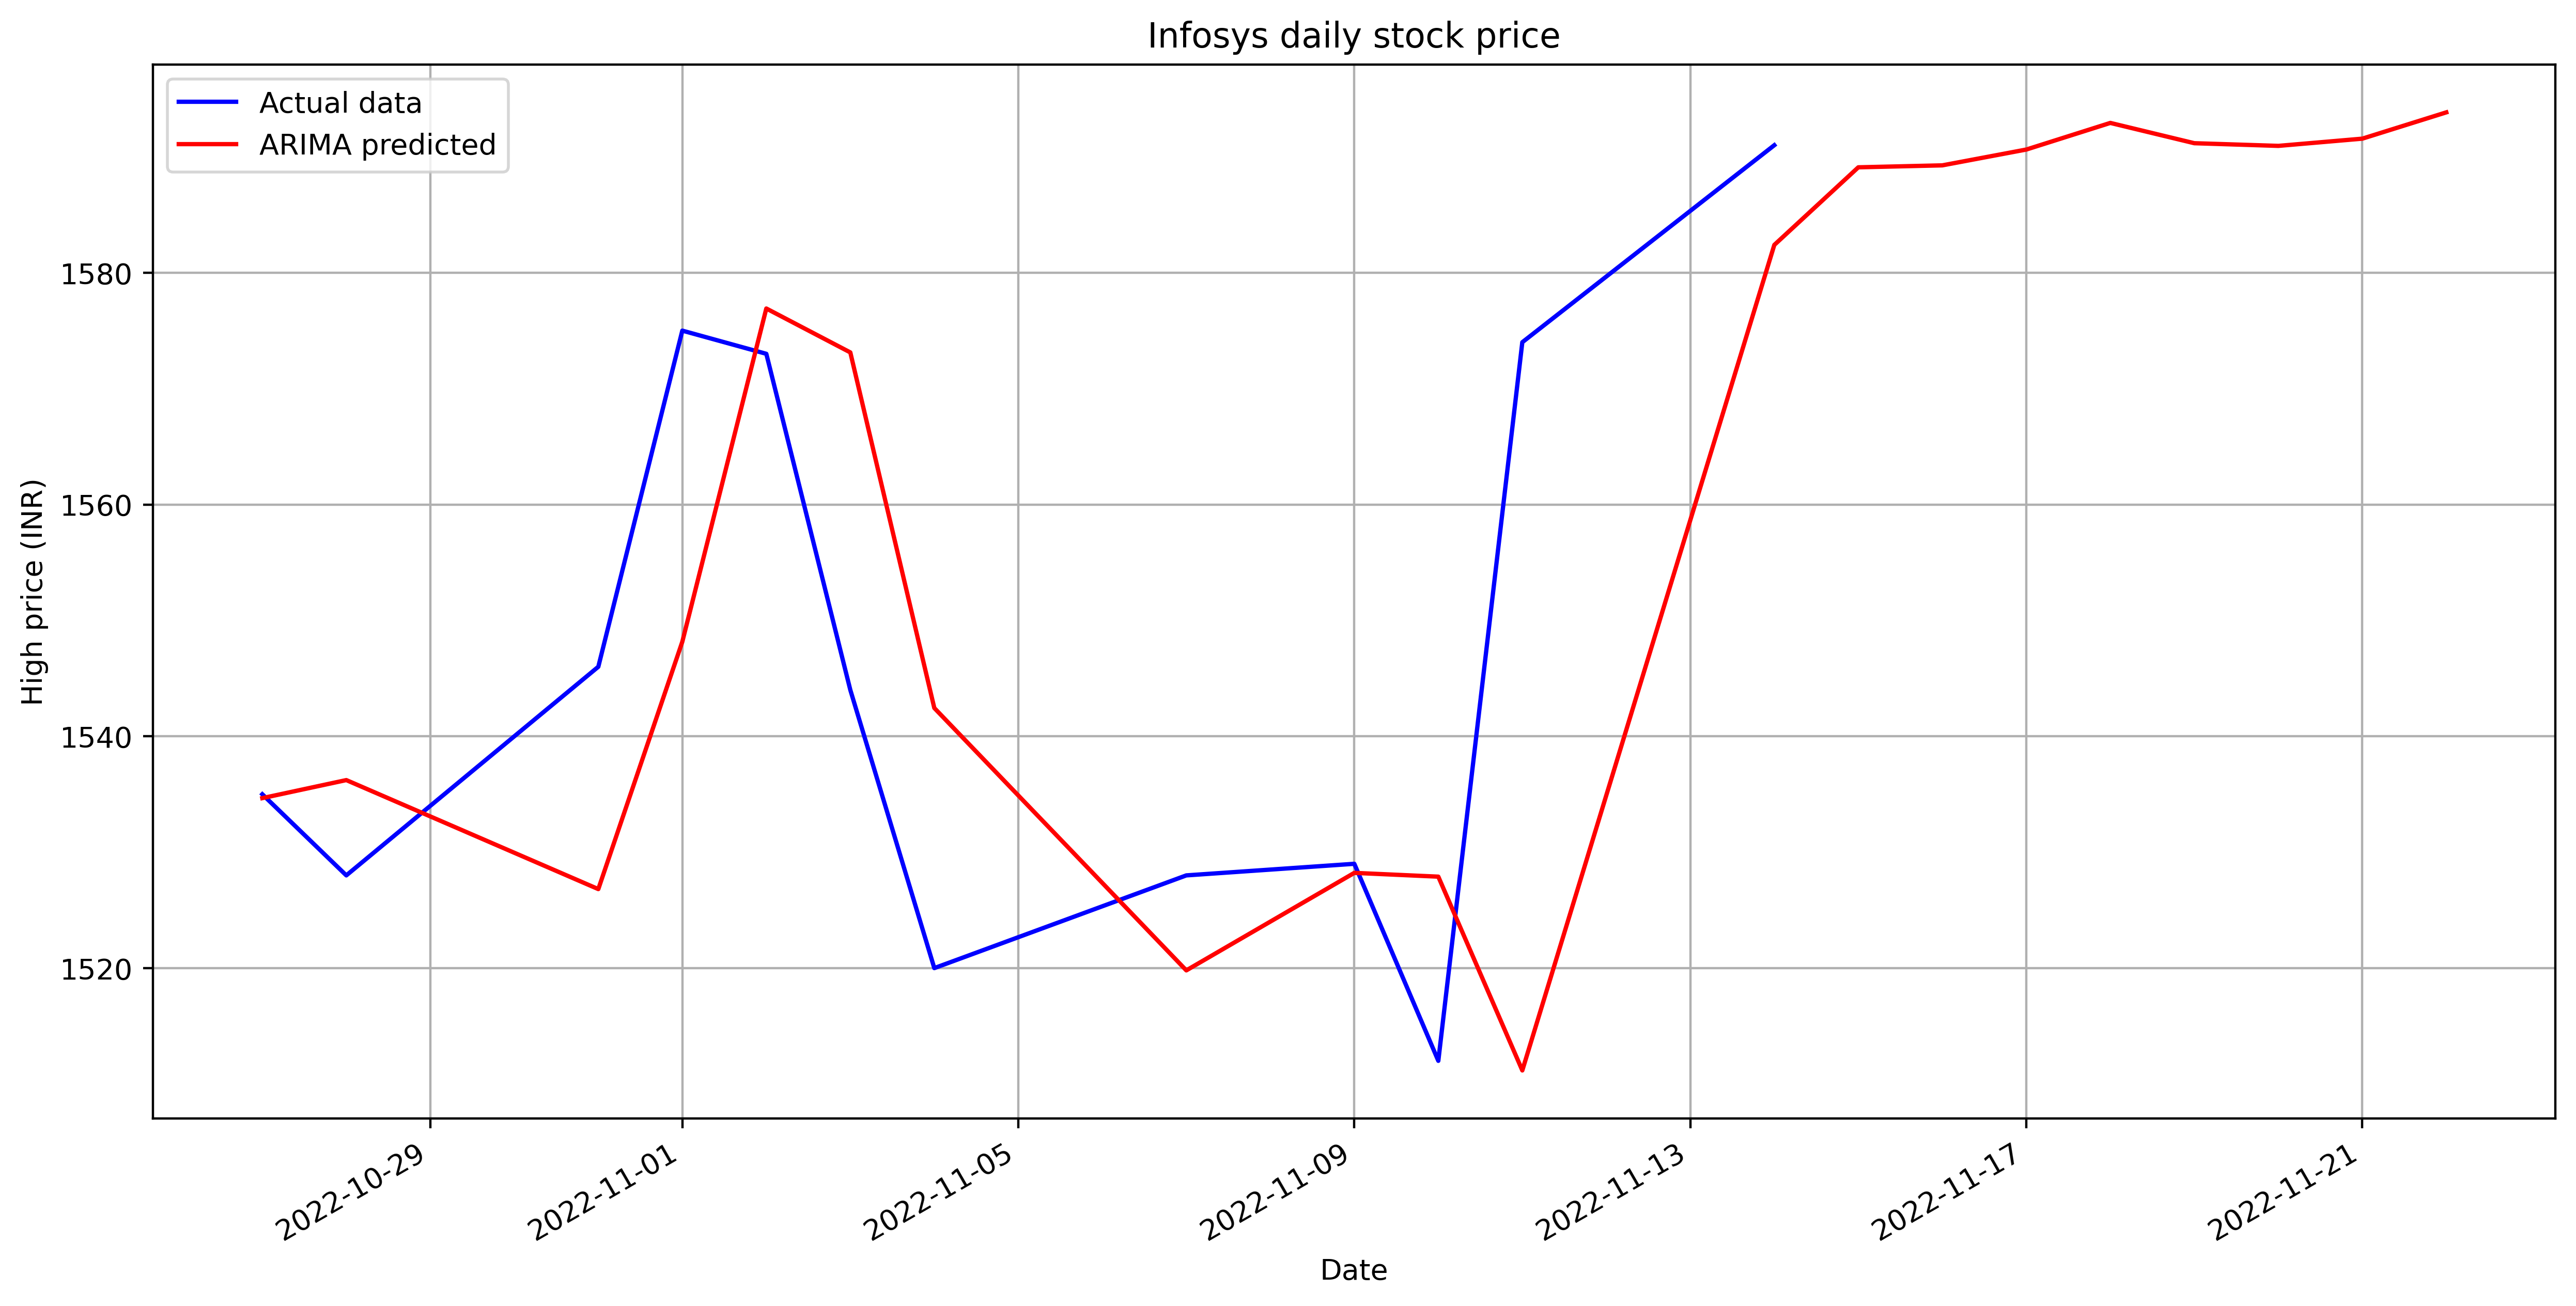

In [7]:
plt.figure(figsize = (15, 7.5), dpi = 400)
plt.xlabel('Date')
plt.title('Infosys daily stock price')
plt.ylabel('High price (INR)')
test_df['High'].plot(color = 'Blue', label = 'Actual data')
prediction.plot(color = 'red', label = 'ARIMA predicted')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
mse = mean_squared_error(df.High.iloc[2263:2274], model_fit.predict(start = 2263, end = 2273))
rmse = sqrt(mse)
print(f'Mean squared error: {mse}')
print(f'Root mean squared error: {rmse}')

Mean squared error: 617.3425291996431
Root mean squared error: 24.84637859326069


# SARIMAX
X - Exogenous variable that means we are having an external cause or origin that means there is some other external factor which is impacting it.

In [9]:
dfs = pd.read_excel('Infosys_Stock_Price_Dataset.xlsx', usecols=['Date', 'High'])

<AxesSubplot: title={'center': 'Infosys daily stock price'}, xlabel='Date', ylabel='High price (INR)'>

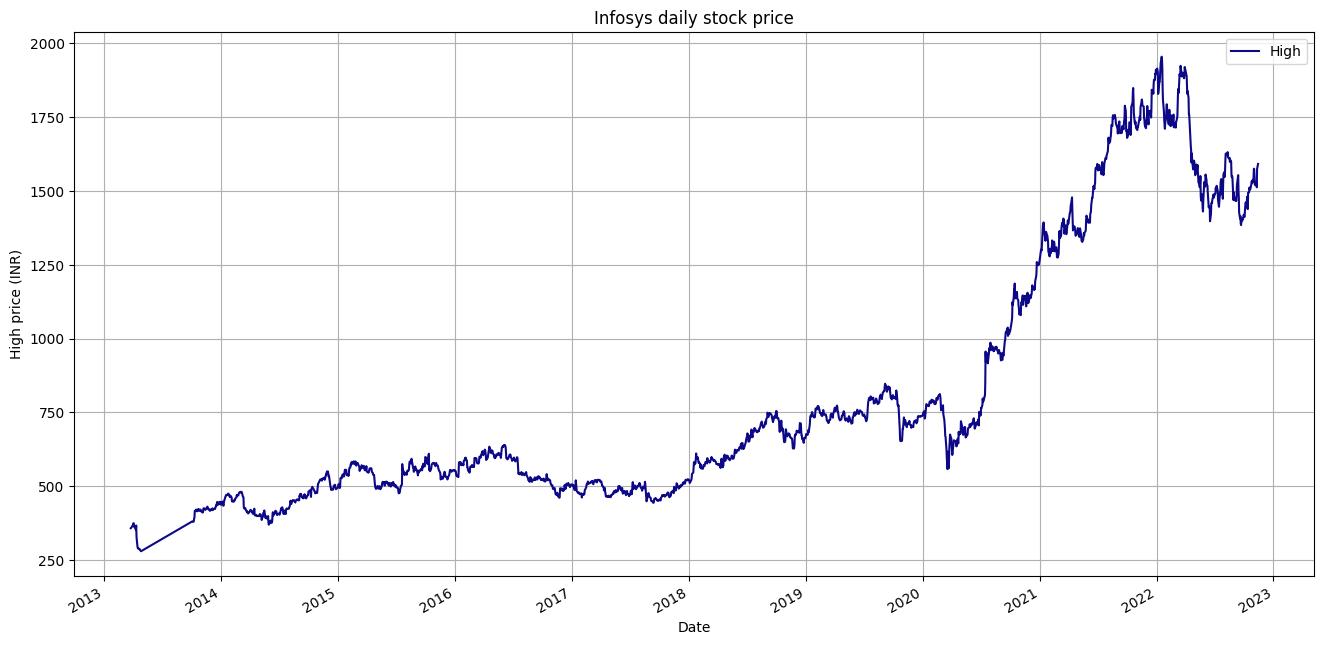

In [10]:
dfs.plot(x = 'Date', y = 'High', figsize=(16,8), title='Infosys daily stock price', grid=True, ylabel='High price (INR)', colormap='plasma')

In [ ]:
plot_pacf(dfs['High'])
plot_acf(dfs['High'])

In [ ]:
ad_fuller_result = adfuller(dfs['High'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Since the p-value is large, we cannot reject the null hypothesis and must assume that the time series is non-stationary.
Now, let’s take the log difference in an effort to make it stationary:

In [ ]:
dfs['High'] = np.log(dfs['High'])
dfs['High'] = dfs['High'].diff()
dfs = dfs.drop(dfs.index[0])

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(dfs['High'])
plt.title("Log Difference of Daily Infosys stock price")
plt.show()

Now the p-value is small enough for us to reject the null hypothesis, and we can consider that the time series is stationary.

In [ ]:
ad_fuller_result = adfuller(dfs['High'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
plot_pacf(dfs['High'])
plot_acf(dfs['High'])

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, dfs['High'])
result_df

In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. AIC is calculated from: the number of independent variables used to build the model. the maximum likelihood estimate of the model (how well the model reproduces the data).

In [ ]:
minm = result_df.AIC.min()
minm

In [ ]:
idx = [indx for indx, itm enumerate(result_df.AIC) if itm == result_df.AIC.min()]
result_df.iloc[idx[0]]

In [11]:
best_model = SARIMAX(dfs['High'], order=(3, 1, 3), seasonal_order=(1, 1, 3, 4)).fit(dis=-1)
best_model.summary()

c:\Users\laxmi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\Users\laxmi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              High   No. Observations:                 2275
Model:             SARIMAX(3, 1, 3)x(1, 1, 3, 4)   Log Likelihood               -9198.210
Date:                           Mon, 28 Nov 2022   AIC                          18418.419
Time:                                   20:00:39   BIC                          18481.422
Sample:                                        0   HQIC                         18441.405
                                          - 2275                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5248      0.315      1.666      0.096      -0.093       1.142
ar.L2          0.5827      0.154      3.780      0.000       0.281       0.885
ar.L3         -0.3832      0.210     -1.821      0.069      -0.796       0.029
ma.L1         -0.4294      0.319     -1.347      0.178      -1.054       0.196
ma.L2         -0.6602      0.137     -4.821      0.000      -0.929      -0.392
ma.L3          0.3658      0.239      1.528      0.126      -0.103       0.835
ar.S.L4       -0.9612      0.049    -19.448      0.000      -1.058      -0.864
ma.S.L4        0.0120      0.057      0.208      0.835      -0.101       0.124
ma.S.L8       -0.9700      0.046    -20.983      0.000      -1.061      -0.879
ma.S.L12      -0.0414      0.022     -1.918      0.055      -0.084       0.001
sigma2       191.0849      4.798     39.824      0.000     181.681     200.489
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              7939.38
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               5.35   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

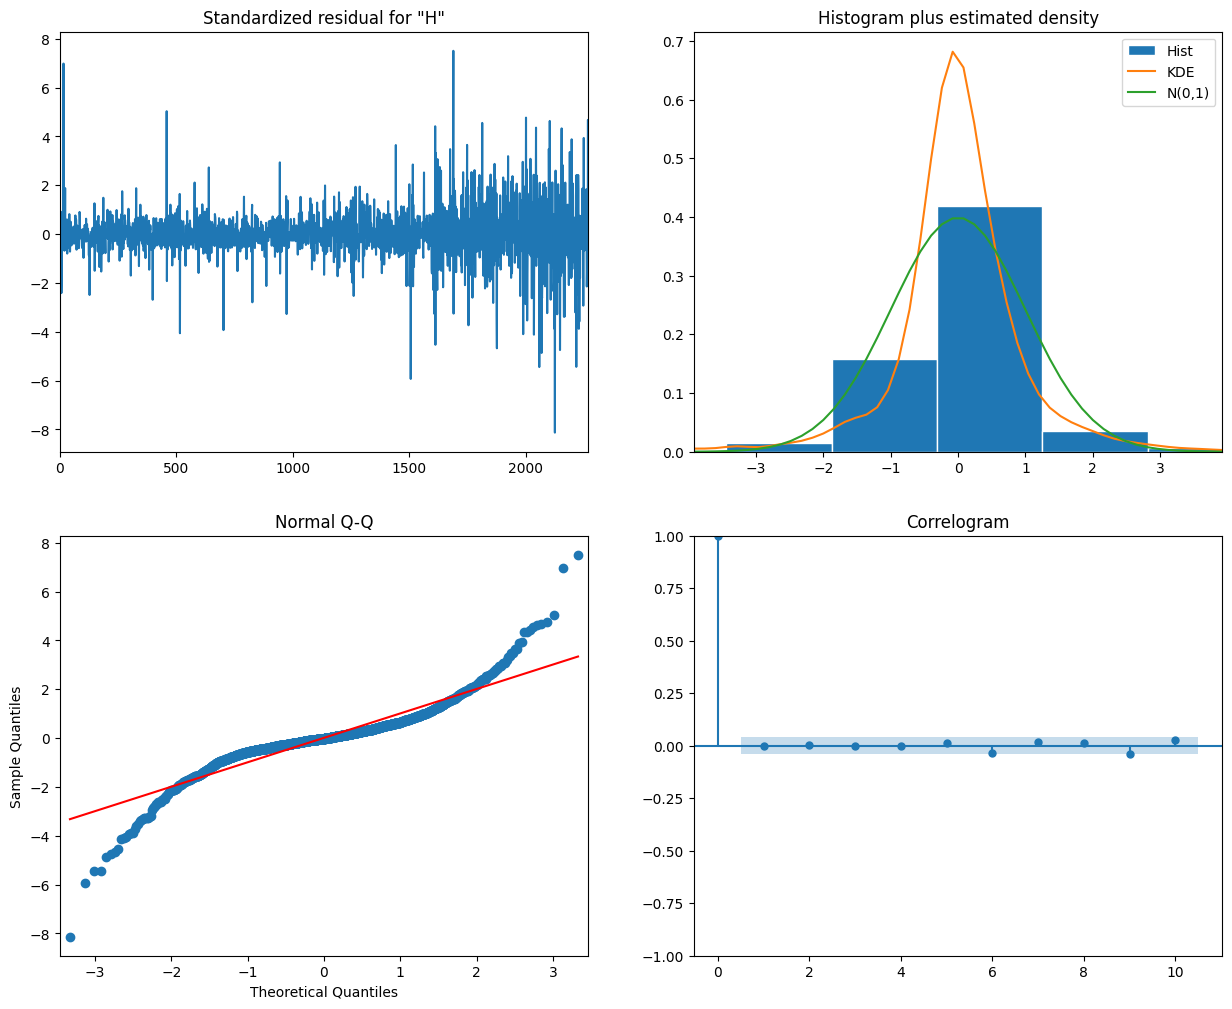

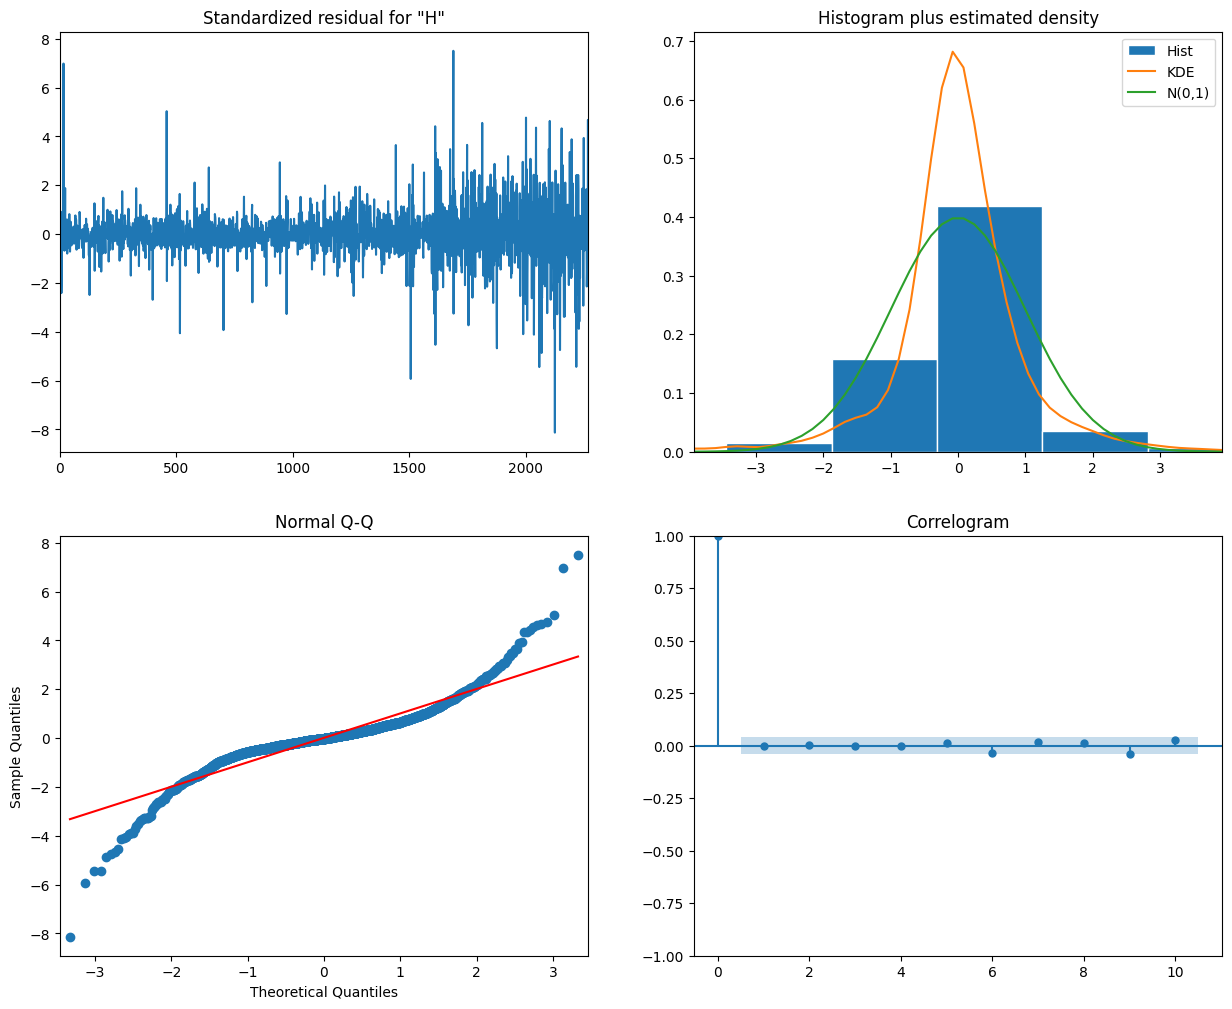

In [12]:
best_model.plot_diagnostics(figsize=(15,12))

In [13]:
future_date = pd.date_range(start = dfs.Date.iloc[-1], periods=10, freq='D')
future_date_dfs = pd.DataFrame(future_date[1:], columns = ['Date'])
dfs = pd.concat([dfs, future_date_dfs], ignore_index = True)

In [14]:
test_dfs = dfs.loc[2263:2282, :]
test_dfs['Date'] = pd.to_datetime(test_dfs['Date'])
test_dfs.set_index('Date', inplace = True)
prediction_s = best_model.predict(start = 2263, end = 2282)
prediction_s.index = test_dfs.index
# prediction = model_fit.predict(start = df.index[-15], end = df.index[-1])

C:\Users\laxmi\AppData\Local\Temp\ipykernel_3952\1087033630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfs['Date'] = pd.to_datetime(test_dfs['Date'])


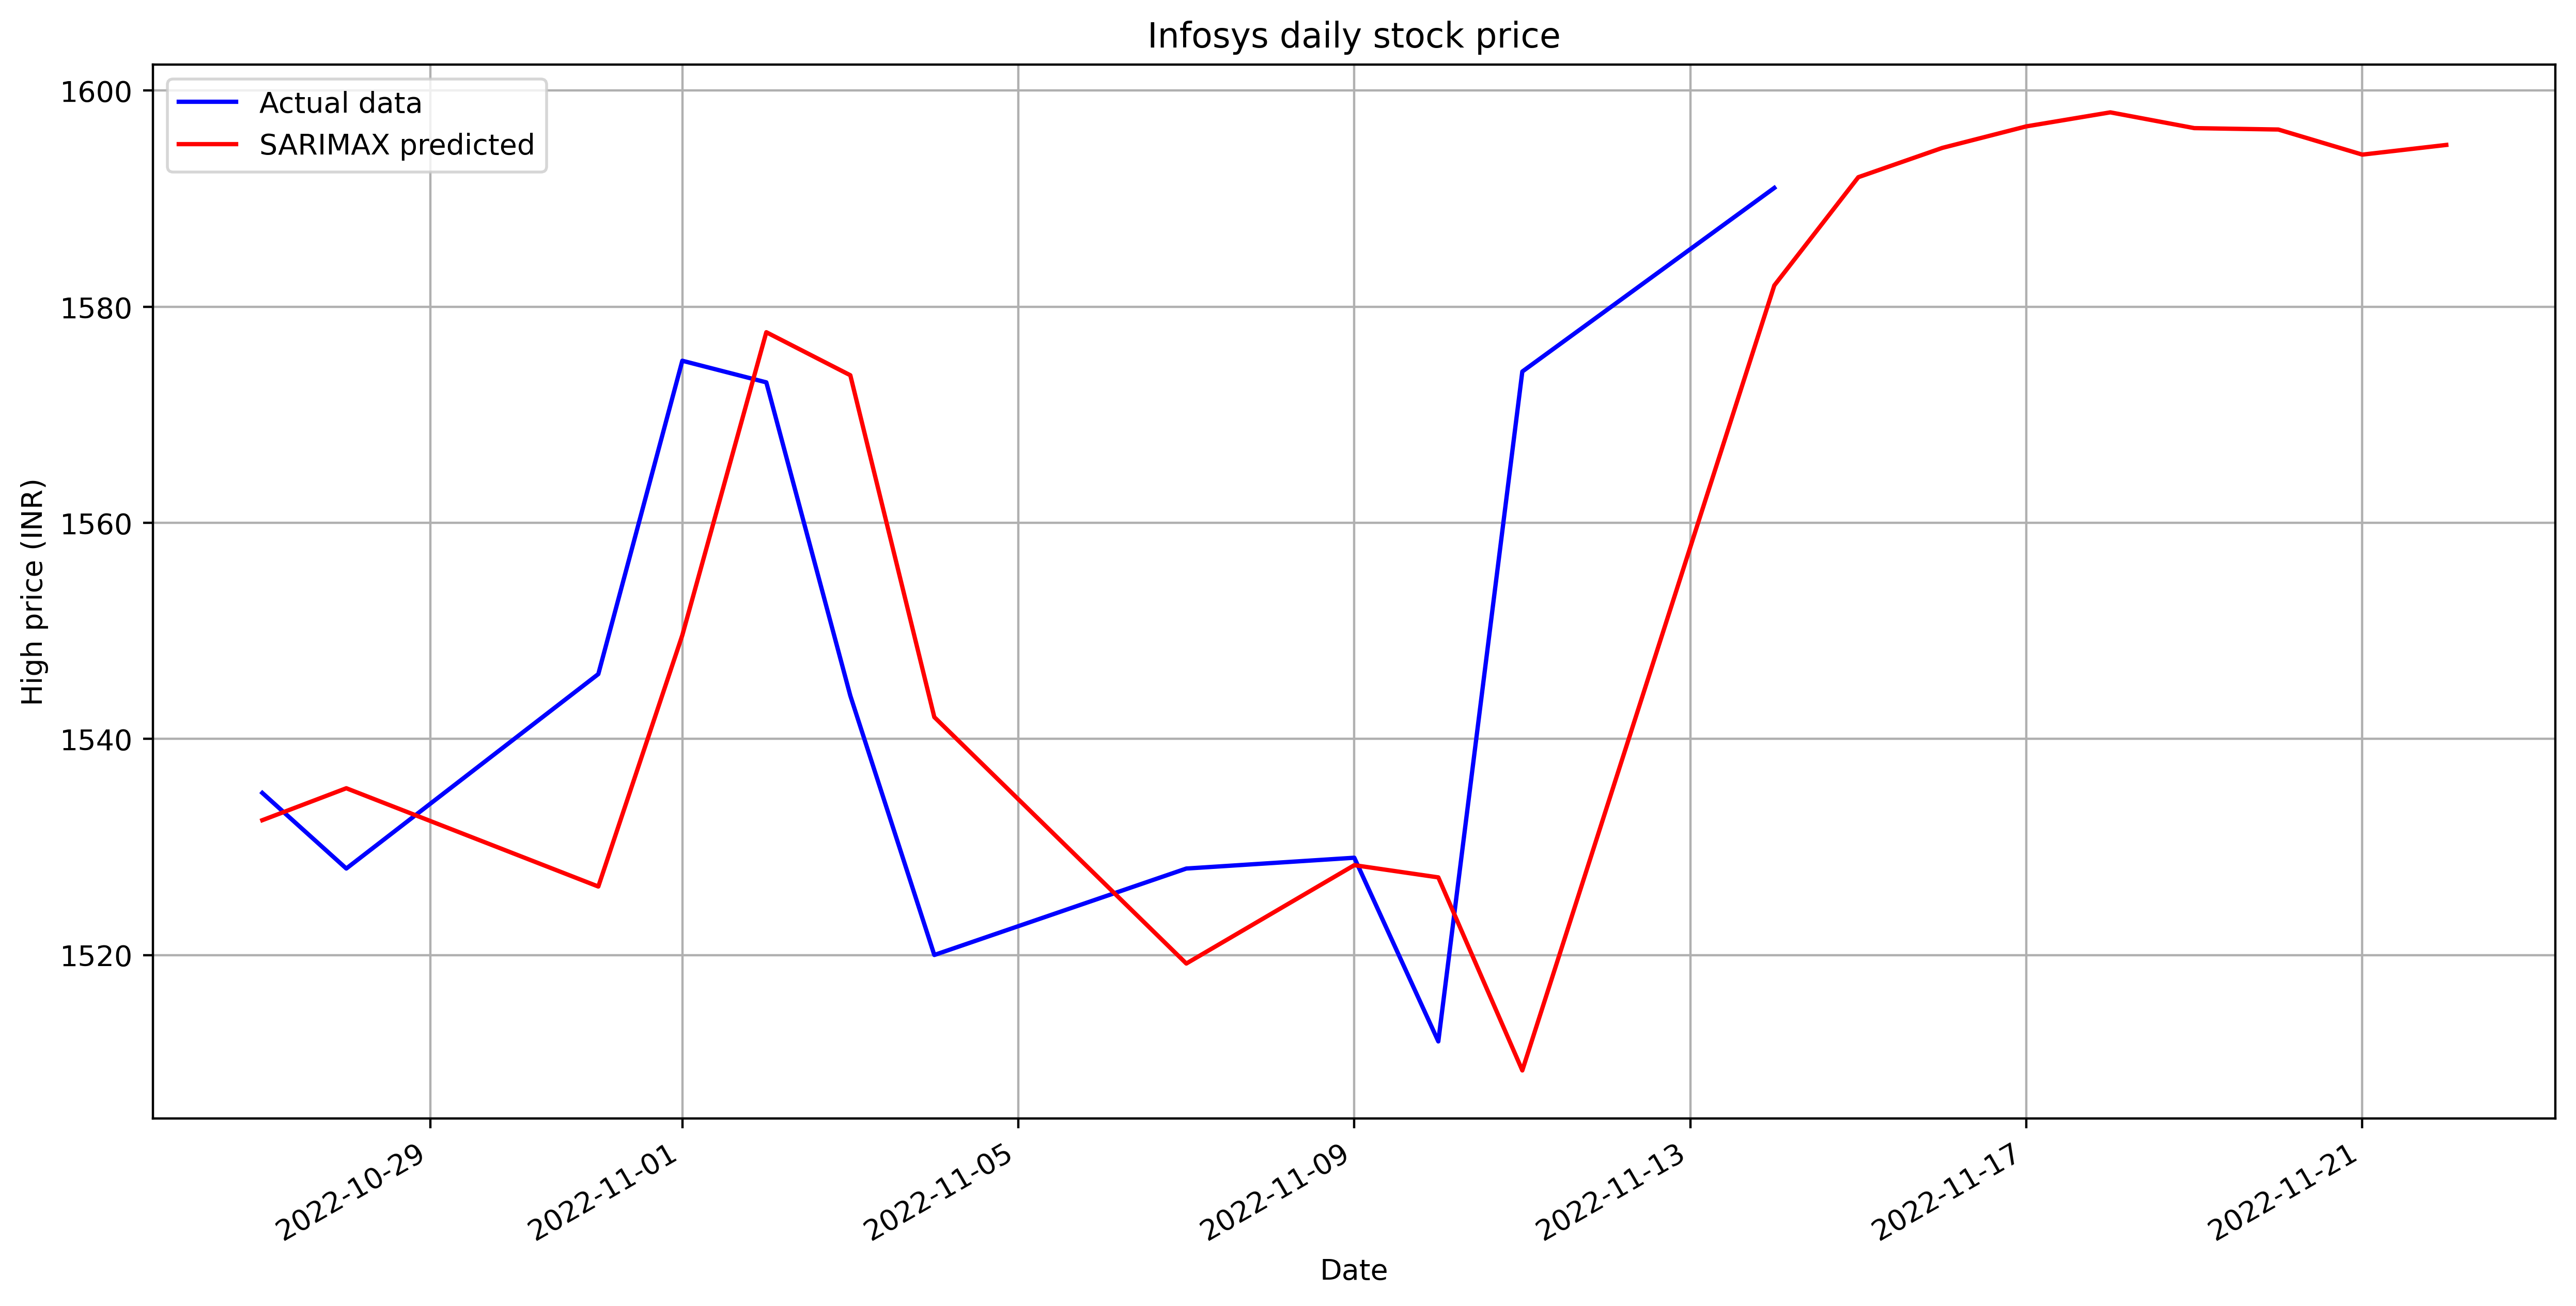

In [17]:
plt.figure(figsize = (15, 7.5), dpi = 400)
plt.xlabel('Date')
plt.title('Infosys daily stock price')
plt.ylabel('High price (INR)')
test_dfs['High'].plot(color = 'Blue', label = 'Actual data')
prediction_s.plot(color = 'red', label = 'SARIMAX predicted')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
mse_s = mean_squared_error(dfs.High.iloc[2263:2274], best_model.predict(start = 2263, end = 2273))
rmse_s = sqrt(mse_s)
print(f'Mean squared error: {mse_s}')
print(f'Root mean squared error: {rmse_s}')

Mean squared error: 633.8498450154752
Root mean squared error: 25.176374739335987
